In [4]:
import numpy as np
# import optuna
import mlflow
import torch
from mlflow import pytorch
from argparse import Namespace
from torch.utils.data import Dataset, DataLoader
from pprint import pformat
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn

import os

import logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')

from trainer import Trainer
from encoder_decoder import EncoderDecoderWrapper

SEGMENT = "segment_1425_1430"

In [5]:
import random
import os
from config import exp_dict_all
import pandas as pd

In [6]:
import matplotlib.pyplot as plt
import pandas as pdp

In [7]:
params = Namespace(batch_size=50,
   in_channels = 2*(len(exp_dict_all[SEGMENT]['inputs']['phases'])), out_channels = 1, sequence_len = 20,rnn_hid_size = 50, output_size=2, teacher_forcing=0.3,
    lr=1e-4,
    num_epochs=1000,
    patience=10,
TIME_SLICE_NAME = 'exemplarid',
store_path = '/blue/ranka/yashaswikarnati/interruption/leakage_modelling/train_data/',
                   processed_run_name = 'run_2022_05_to_08_ts_yash',  data_params = {'inp_agg_level':4,
                          'oup_agg_level':20,
                      'oup_window_use': (0,40)}, segment_name = SEGMENT
)


logging.info(f"{torch.cuda.is_available()}, {torch.cuda.get_device_name(0)}")
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

EXP_NAME = SEGMENT
# mlflow.set_experiment(experiment_name=EXP_NAME)
LOAD_PRETRAINED = True
pretrained_epoch = 998

2022-11-07 16:28:08 INFO     True, NVIDIA A100-SXM4-80GB


In [106]:
# # train block
print(f"starting exp name {EXP_NAME}")
with mlflow.start_run(run_name=EXP_NAME) as run:
    # logging.info(f"model initialized")
    model =  EncoderDecoderWrapper(in_channels = params.in_channels, out_channels = params.out_channels,
                                    sequence_len = params.sequence_len,rnn_hid_size = params.rnn_hid_size, device = device, spatial_inp_size= 4 + int(params.in_channels/2),output_size=params.output_size,
                                    teacher_forcing=params.teacher_forcing,learning_rate = params.lr)
    # logging.info(f"model loaded")
#     model = nn.DataParallel(model).cuda()
    
    if(LOAD_PRETRAINED):
        print(f"loading pretrained model {EXP_NAME}_epoch_{pretrained_epoch}.pth")
        model.load_state_dict(torch.load(f'pthfiles/{EXP_NAME}_epoch_{pretrained_epoch}.pth'))

    trainer_obj =  Trainer(
        model  = model,
        device = device,
        exp_name = EXP_NAME,
        exp = 'segment_leak',
        loss_fn = torch.nn.MSELoss()
    )

    mlflow.log_params(vars(params))
    train_loader, val_loader = trainer_obj.get_dataloaders(params.batch_size,params.store_path,params.processed_run_name,params.data_params)
    logging.info(f"train and val loader objects created")
    train_loader, val_loader = trainer_obj.get_dataloaders(params.batch_size,params.store_path,params.processed_run_name,params.data_params, params.segment_name)

starting exp name segment_1460_1465


2022/10/04 10:58:30 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



TypeError: get_dataloaders() missing 1 required positional argument: 'segment_name'

In [8]:
# testing

model =  EncoderDecoderWrapper(in_channels = params.in_channels, out_channels = params.out_channels,
                                    sequence_len = params.sequence_len,rnn_hid_size = params.rnn_hid_size, device = device, spatial_inp_size= 4 + int(params.in_channels/2),output_size=params.output_size,
                                    teacher_forcing=params.teacher_forcing,learning_rate = params.lr)
# logging.info(f"model loaded")
#     model = nn.DataParallel(model).cuda()

if(LOAD_PRETRAINED):
    print(f"loading pretrained model {EXP_NAME}_epoch_{pretrained_epoch}.pth")
    model.load_state_dict(torch.load(f'pthfiles/{EXP_NAME}_epoch_{pretrained_epoch}.pth'))

trainer_obj =  Trainer(
    model  = model,
    device = device,
    exp_name = EXP_NAME,
    exp = 'segment_leak',
    loss_fn = torch.nn.MSELoss()
)

train_loader, val_loader = trainer_obj.get_dataloaders(params.batch_size,params.store_path,params.processed_run_name,params.data_params, params.segment_name)

loading pretrained model segment_1425_1430_epoch_998.pth


2022-11-07 16:29:02 INFO     TRAIN SET SIZE 8992 VALIDATION SET SIZE 2247


In [25]:
data['sig'].shape

torch.Size([47, 20, 2])

In [16]:
trainer_obj.model.eval()
val_set_size = len(val_loader.dataset)
val_loss = 0
correct = 0
all_percent_errors = []
all_actual = []
all_pred = []
all_times_of_day = []
all_days_of_week =[]
all_inputs_major = []
all_inputs_all = []


with torch.no_grad():
    for data in val_loader:
        output = model(data)
        actual =  data['y'].detach().numpy()[:,:,0].flatten()
        pred = output.cpu().detach().numpy()[:,:,0].flatten()
        
        time_of_day = data['params'][:,2].detach().numpy()
        time_of_day = np.concatenate([time_of_day[:,np.newaxis], time_of_day[:,np.newaxis]], axis =1).flatten()
        day_of_week = data['params'][:,3].detach().numpy()
        day_of_week = np.concatenate([day_of_week[:,np.newaxis], day_of_week[:,np.newaxis]], axis =1).flatten()
        day_of_week = np.concatenate([day_of_week[:,np.newaxis], day_of_week[:,np.newaxis]], axis =1).flatten()
        
        inp_major_1,inp_major_2  = np.sum((data['x'][:,10:15,0].detach().numpy()),  axis = 1), np.sum((data['x'][:,15:,0].detach().numpy()),  axis = 1)
        inp_major = np.concatenate([inp_major_1[:,np.newaxis], inp_major_2[:,np.newaxis]], axis = 1).flatten()
        inp_all_1,inp_all_2  = np.sum((data['x'][:,10:15,:].detach().numpy()),  axis = (1,2)), np.sum((data['x'][:,15:,:].detach().numpy()),  axis = (1,2))
        inp_all = np.concatenate([inp_all_1[:,np.newaxis], inp_all_2[:,np.newaxis]], axis = 1).flatten()
        
        
        
        
        
        non_zero_indices = np.where(actual>0)[0]
        actual = actual[non_zero_indices]
        pred = pred[non_zero_indices]
        time_of_day = time_of_day[non_zero_indices]
        day_of_week = day_of_week[non_zero_indices]
        inp_major = inp_major[non_zero_indices]
        inp_all = inp_all[non_zero_indices]
        
        
        
        
        
        all_actual.extend(list(actual))
        all_pred.extend(list(pred))
        all_times_of_day.extend(list(time_of_day))
        all_days_of_week.extend(list(day_of_week))
        all_inputs_major.extend(list(inp_major))
        all_inputs_all.extend(list(inp_all))
        
        curr_loss = trainer_obj.criterion(output, data['y'].float().to(trainer_obj.device)).item()
        print(f"curr_loss {curr_loss}")
        percent_error = ( np.abs(actual-pred)/(actual))*100
        print(f"percent error {np.mean(percent_error)}")
        all_percent_errors.extend(list(percent_error.flatten()))
        val_loss += curr_loss # sum up batch loss         


val_loss /=  len(val_loader)

curr_loss 16.770084381103516
percent error 8.62890628993984
curr_loss 15.237550735473633
percent error 7.476193976031493
curr_loss 14.1934814453125
percent error 7.8083505475048165
curr_loss 12.186386108398438
percent error 7.3524940949026405
curr_loss 10.252168655395508
percent error 6.215984496869811
curr_loss 13.74896240234375
percent error 7.434047381202582
curr_loss 15.100939750671387
percent error 7.668852458834104
curr_loss 15.912004470825195
percent error 8.64255457711405
curr_loss 13.30526065826416
percent error 7.7282182014440775
curr_loss 20.65138053894043
percent error 8.513825722935538
curr_loss 15.650711059570312
percent error 7.775511801110086
curr_loss 16.4830322265625
percent error 7.998880254922169
curr_loss 15.423196792602539
percent error 8.14873892718604
curr_loss 20.842493057250977
percent error 8.804893376762475
curr_loss 11.118185997009277
percent error 7.320463562318694
curr_loss 21.472835540771484
percent error 10.17167438419269
curr_loss 14.111696243286133
pe

In [17]:
import pandas as pd

In [18]:
error_df = pd.DataFrame()
error_df['actual'] = all_actual
error_df['predicted'] = all_pred
error_df['input_major'] = all_inputs_major
error_df['inputs_all'] = all_inputs_all
error_df['percent_error'] = all_percent_errors
error_df['time_of_day'] = all_times_of_day
error_df['day_of_week'] = all_days_of_week
error_df['diff_major'] =  error_df['input_major'] - error_df['actual']
error_df['diff_all_inp'] =  error_df['inputs_all'] - error_df['actual']
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
error_df['weekday'] = error_df['day_of_week'].map(dayOfWeek)
error_df['segment'] = SEGMENT
error_df.to_csv(f'res_store/error_{SEGMENT}.csv')

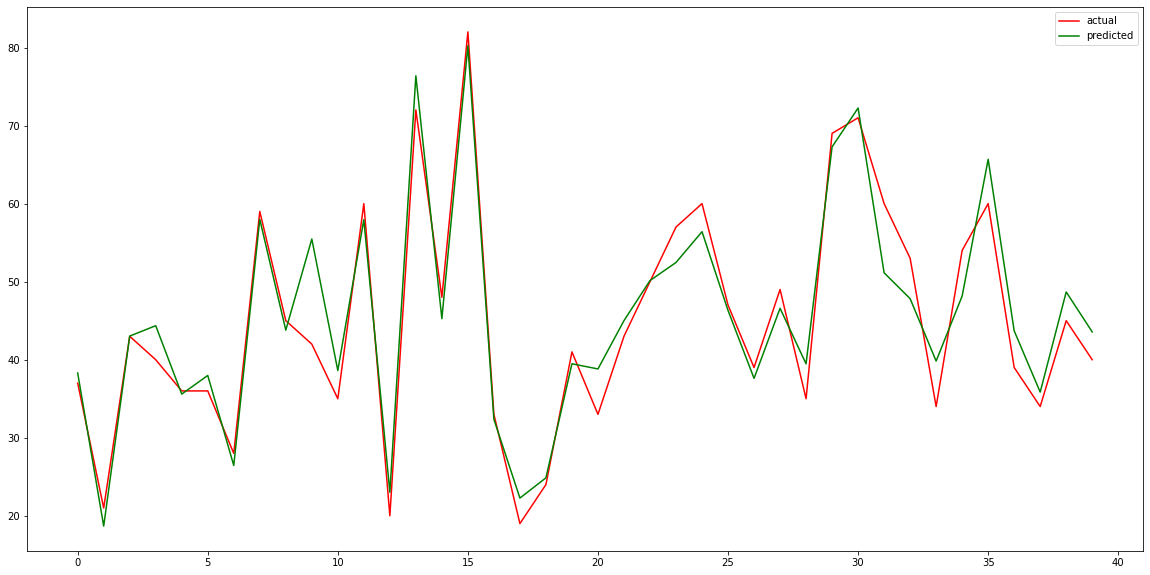

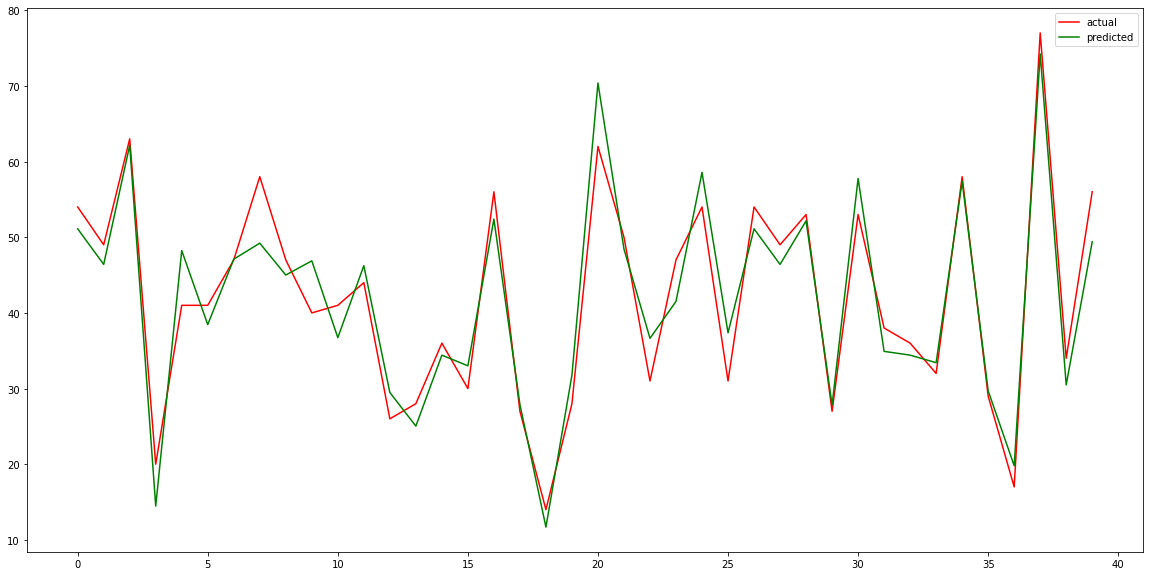

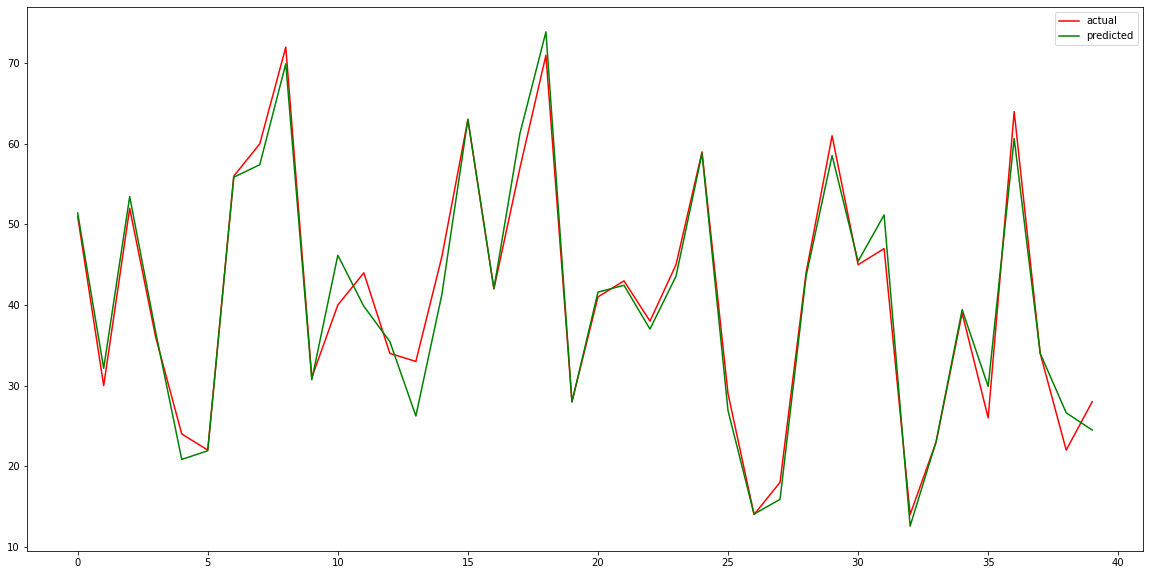

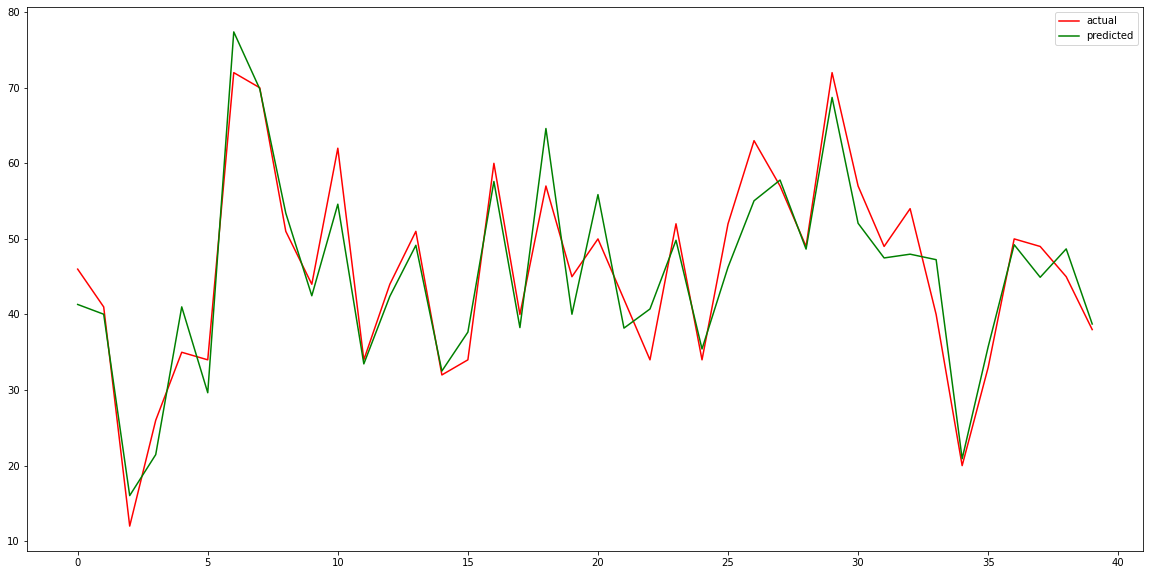

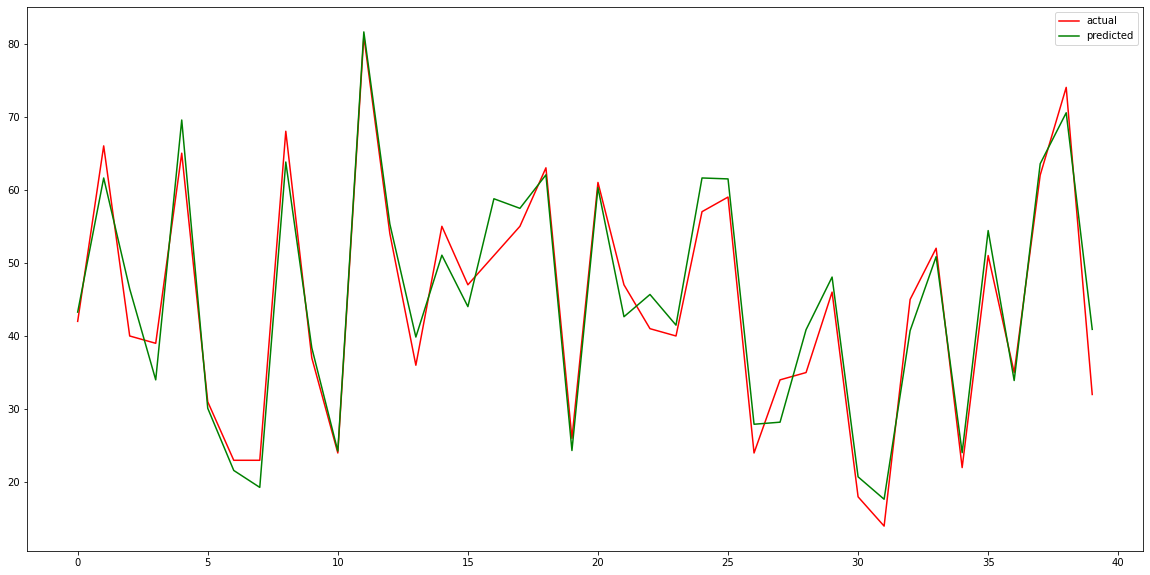

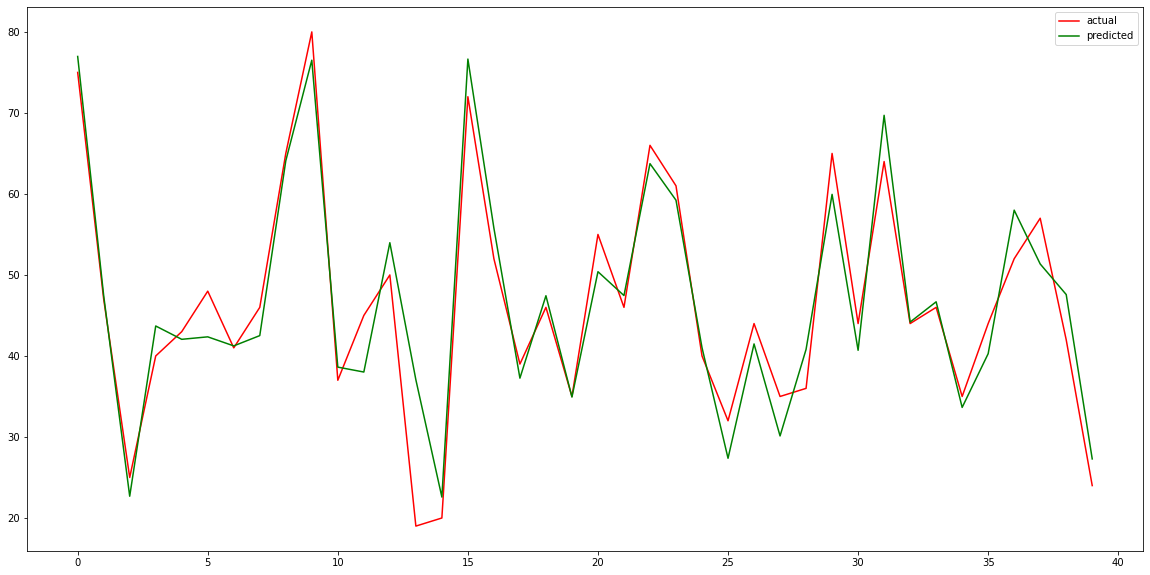

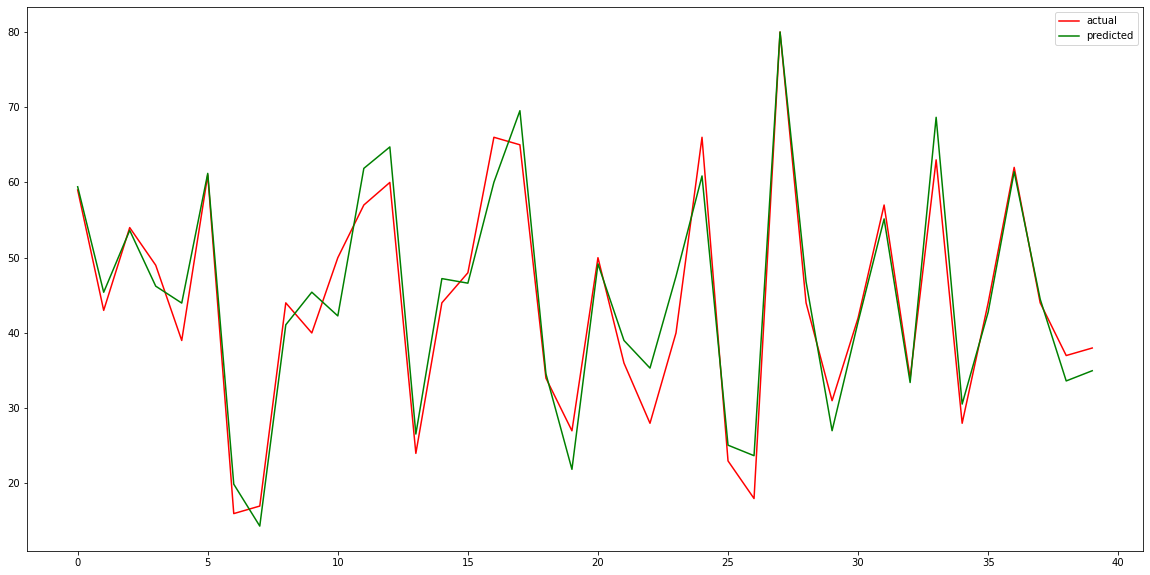

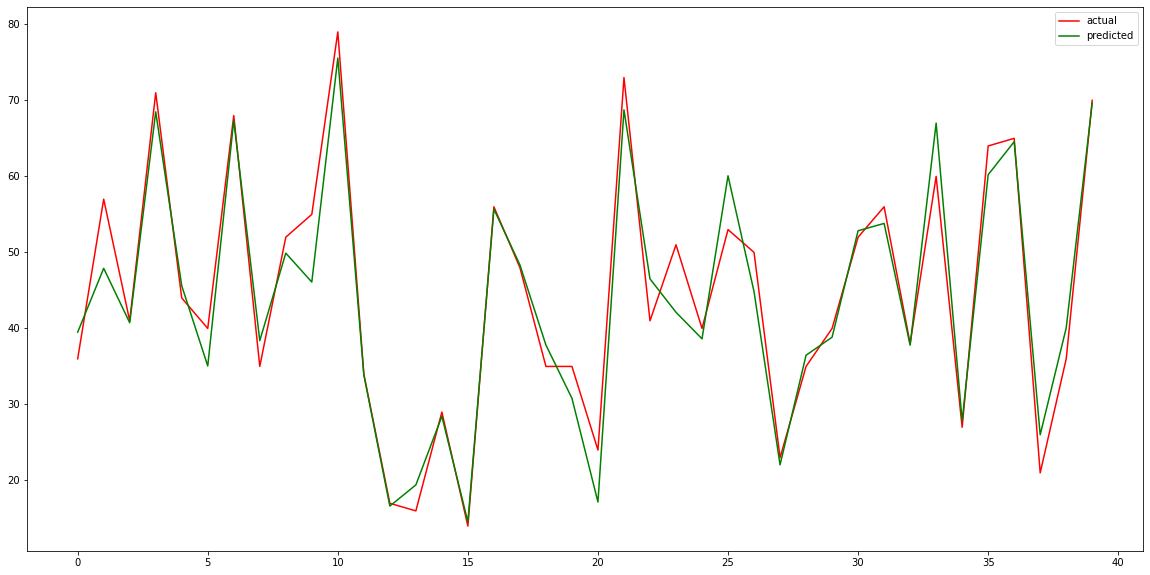

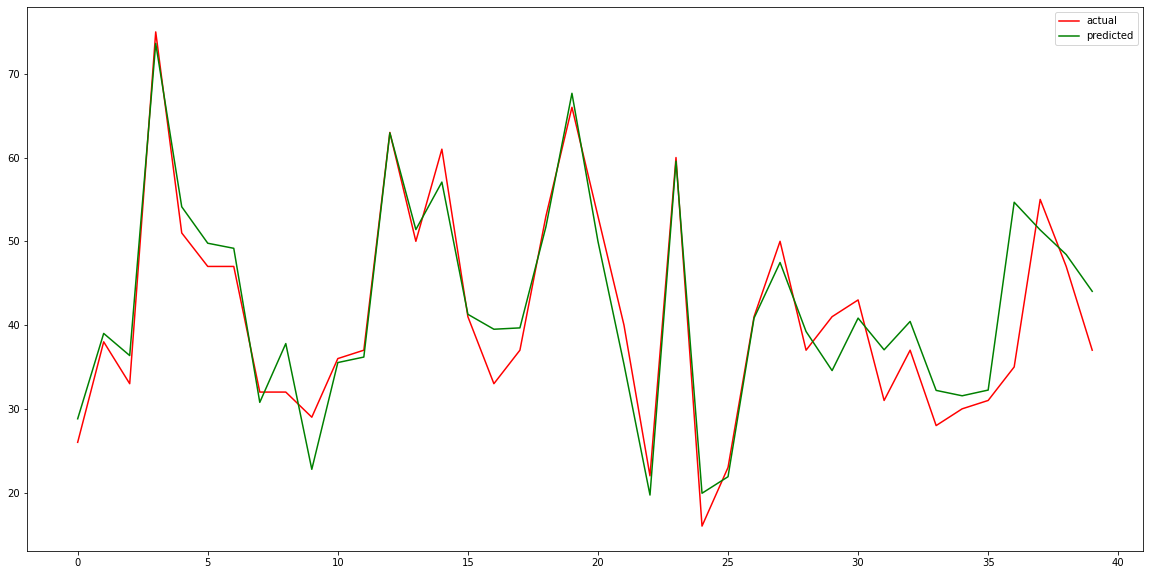

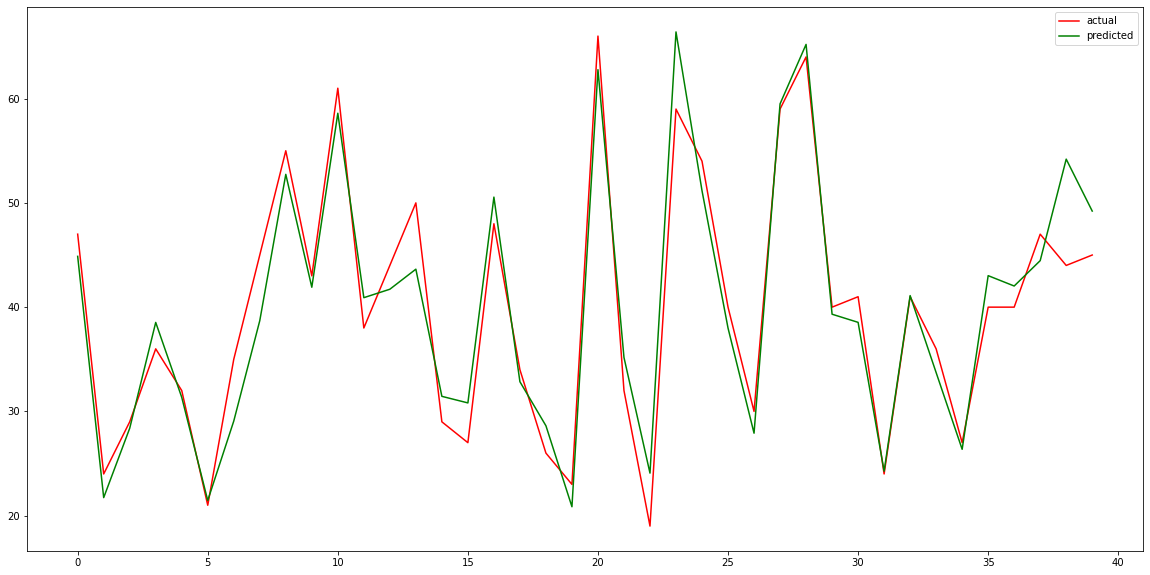

In [19]:

count = 0

while(count<10):
    temp_batch = next(iter(val_loader))
    temp_out = model(temp_batch)
    single_plot_exemplars = 20
    sample_size = temp_batch['y'].shape[0]
    sample_indices = random.sample(range(0, sample_size), single_plot_exemplars)
    actual = temp_batch['y'][sample_indices].detach().numpy().reshape(-1)
    pred = temp_out.cpu().detach().numpy()[sample_indices].reshape(-1)
    fig = plt.figure(figsize = (20,10))
    plt.plot(actual, 'r',label = 'actual')
    plt.plot(pred, 'g', label = 'predicted')
    plt.legend()
    plt.show()
    count+=1



In [10]:
error_df

,actual,predicted,input_major,inputs_all,percent_error,time_of_day,day_of_week,diff_major,diff_all_inp,weekday,segment
0,30,33.098934,33,37,10.329781,15,6,3,7,Sunday,segment_1425_1430
1,58,60.115540,59,64,3.647482,15,6,1,6,Sunday,segment_1425_1430
2,35,34.623108,29,36,1.076835,18,6,-6,1,Sunday,segment_1425_1430
3,26,24.454174,24,29,5.945484,18,6,-2,3,Sunday,segment_1425_1430
4,47,40.997646,52,53,12.770965,15,6,5,6,Sunday,segment_1425_1430
...,...,...,...,...,...,...,...,...,...,...,...
4485,50,49.618443,38,45,0.763115,14,0,-12,-5,Monday,segment_1425_1430
4486,36,37.128227,30,33,3.133965,13,0,-6,-3,Monday,segment_1425_1430
4487,37,39.844902,61,65,7.688924,13,0,24,28,Monday,segment_1425_1430
4488,54,52.963993,39,43,1.918531,7,4,-15,-11,Friday,segment_1425_1430


In [11]:
error_df[error_df.percent_error > 70]

,actual,predicted,input_major,inputs_all,percent_error,time_of_day,day_of_week,diff_major,diff_all_inp,weekday,segment
191,6,22.466297,29,31,274.438286,10,1,23,25,Tuesday,segment_1425_1430
420,15,29.086584,35,46,93.910561,16,3,20,31,Thursday,segment_1425_1430
1078,12,29.671804,35,38,147.265037,15,0,23,26,Monday,segment_1425_1430
1104,14,26.017286,39,47,85.837759,11,1,25,33,Tuesday,segment_1425_1430
1799,11,19.627266,20,21,78.429690,20,3,9,10,Thursday,segment_1425_1430
1893,29,49.625832,63,65,71.123557,18,4,34,36,Friday,segment_1425_1430
2113,8,14.582021,12,16,82.275259,20,0,4,8,Monday,segment_1425_1430
2190,27,50.606129,45,49,87.430106,18,4,18,22,Friday,segment_1425_1430
2436,10,28.793993,25,33,187.939930,16,6,15,23,Sunday,segment_1425_1430
2951,29,49.625832,63,65,71.123557,18,6,34,36,Sunday,segment_1425_1430


In [13]:
import plotly
import plotly.express as px

In [16]:
# px.scatter(error_df, x='actual', y='predicted', color='weekday')

In [40]:
error_df[error_df.percent_error > 70]

,actual,predicted,input_major,inputs_all,percent_error,time_of_day,day_of_week,diff_major,diff_all_inp,weekday,segment
264,7,12.220461,20,24,74.578013,11,1,13,17,Tuesday,segment_1430_1435
493,1,6.501145,14,18,550.114536,16,2,13,17,Wednesday,segment_1430_1435
587,5,8.570956,14,20,71.419125,16,0,9,15,Monday,segment_1430_1435
679,7,12.087274,17,26,72.675337,13,1,10,19,Tuesday,segment_1430_1435
951,12,20.927469,24,29,74.395577,16,4,12,17,Friday,segment_1430_1435
1135,6,11.100616,16,25,85.010258,16,3,10,19,Thursday,segment_1430_1435
1507,2,8.792535,17,20,339.626741,17,2,15,18,Wednesday,segment_1430_1435
1672,5,11.128705,18,24,122.574100,14,1,13,19,Tuesday,segment_1430_1435
2006,5,9.753908,15,21,95.078163,17,3,10,16,Thursday,segment_1430_1435
2264,4,7.197392,14,19,79.934800,8,5,10,15,Saturday,segment_1430_1435


In [12]:
px.scatter(error_df[error_df.percent_error < 70], x="actual", y="percent_error")


NameError: name 'px' is not defined

In [188]:
temp_error = error_df[error_df.percent_error < 70]

In [199]:
fig = px.scatter_3d(temp_error, x='actual', y='diff_major', z='percent_error',
                    color='percent_error')
fig.show()

In [15]:
px.box(error_df[error_df.percent_error < 70], x="time_of_day", y="percent_error")

In [194]:
temp_error

,actual,predicted,input_major,inputs_all,percent_error,time_of_day,day_of_week,diff_major,diff_all_inp,weekday
0,65,61.644772,52,58,5.161890,8,3,-13,-7,Thursday
1,22,17.853771,29,37,18.846495,8,3,7,15,Thursday
2,216,181.263733,198,200,16.081605,7,3,-18,-16,Thursday
3,98,92.854637,92,118,5.250370,7,3,-6,20,Thursday
4,52,60.553596,58,61,16.449224,15,1,6,9,Tuesday
...,...,...,...,...,...,...,...,...,...,...
3566,102,93.774063,90,92,8.064644,14,2,-12,-10,Wednesday
3567,77,70.878403,68,72,7.950126,18,2,-9,-5,Wednesday
3568,6,7.874575,15,26,31.242911,18,2,9,20,Wednesday
3569,32,33.177361,38,44,3.679252,12,4,6,12,Friday


In [195]:
import plotly.graph_objects as go

In [205]:
x, y = temp_error['actual'].values, temp_error['input_major'].values
z = temp_error['percent_error'].values
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
# fig.update_layout(title='Mt Bruno Elevation', autosize=False,
#                   width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90))
# fig.show()

In [206]:
fig.write_html("surface_plot.html")

In [4]:
import pandas as pd
import os
import glob

In [5]:
all_csv = glob.glob(f"res_store/*.csv")

In [6]:
all_files = []
for each_file in all_csv:
    all_files.append(pd.read_csv(each_file))

In [7]:
final_res = pd.concat(all_files)

In [8]:
final_res

,Unnamed: 0,actual,predicted,input_major,inputs_all,percent_error,time_of_day,day_of_week,diff_major,diff_all_inp,weekday,segment
0,0,41,40.079740,39,46,2.244540,7,1,-2,5,Tuesday,segment_1455_1460
1,1,90,90.706590,86,87,0.785099,7,1,-4,-3,Tuesday,segment_1455_1460
2,2,19,17.351025,14,20,8.678818,18,1,-5,1,Tuesday,segment_1455_1460
3,3,94,93.002320,96,98,1.061362,18,1,2,4,Tuesday,segment_1455_1460
4,4,37,34.252525,22,25,7.425607,10,4,-15,-12,Friday,segment_1455_1460
...,...,...,...,...,...,...,...,...,...,...,...,...
4007,4007,73,71.297170,71,75,2.332640,13,6,-2,2,Sunday,segment_1440_1445
4008,4008,58,59.519115,61,74,2.619165,12,6,3,16,Sunday,segment_1440_1445
4009,4009,24,20.179129,22,36,15.920297,12,6,-2,12,Sunday,segment_1440_1445
4010,4010,81,78.863520,63,69,2.637632,9,5,-18,-12,Saturday,segment_1440_1445


In [11]:
final_res.drop(columns = ['Unnamed: 0'], inplace = True)

In [12]:
final_res.to_csv('res_store/all_seg_sr436-1.csv')